In [1]:
import bct
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io
import math
import enum

ModuleNotFoundError: No module named 'bct'

## PARAMETERS

In [2]:
node_count = 100 
simulated_graph_count = 5
number_of_attacks = 100
degree_count = 50

assert degree_count < node_count

In [3]:

base_exponential = nx.random_regular_graph(degree_count,node_count)

base_scale_free = nx.barabasi_albert_graph(node_count, degree_count, seed=np.random.seed(1))

G_list = [base_exponential, base_scale_free]

In [4]:
def plot_strength_dist(G_list):
    for G in G_list:
        strengths = [G[e[0]][e[1]]['weight'] for e in G.edges()]
        plt.hist(strengths)
    plt.ylabel("P(s)")
    plt.xlabel("s")
    plt.title("Strength Distribution")
    plt.show()

def plot_degree_dist(G_list):
    for G in G_list:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees)
    plt.ylabel("P(d)")
    plt.xlabel("d")
    plt.title("Degree Distribution")
    plt.show()

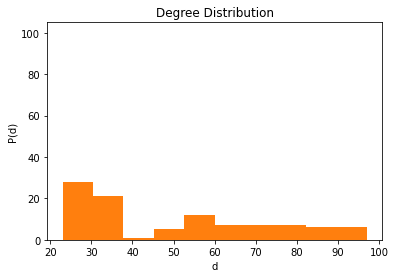

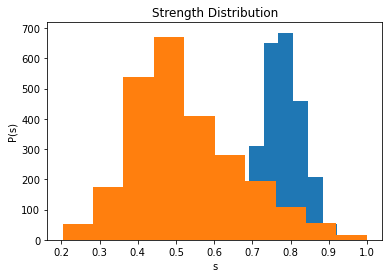

In [5]:
def assignWeightToEdges(G):
    edges_weight = nx.edge_betweenness_centrality(G, normalized=False)
    maximum = max(edges_weight, key=edges_weight.get) 
    #Normalize with max edge weight
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (edges_weight[e] / edges_weight[maximum])

assignWeightToEdges(base_exponential)
assignWeightToEdges(base_scale_free)

G_base_list = [base_exponential, base_scale_free]

plot_degree_dist(G_base_list)
plot_strength_dist(G_base_list)

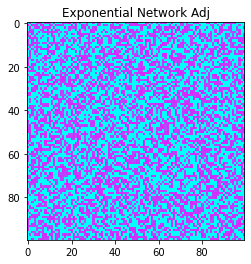

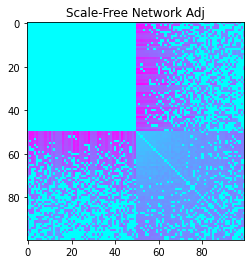

In [6]:
def visuliazeAdj(G, name=""):
    data = nx.to_numpy_array(G)
    plt.imshow(data, cmap='cool', interpolation='nearest')
    plt.title(name)
    plt.show()

visuliazeAdj(base_exponential, "Exponential Network Adj")
visuliazeAdj(base_scale_free, "Scale-Free Network Adj")

In [7]:
#print(nx.to_numpy_array(base_scale_free))
from IPython.display import clear_output

def Null_Model(base_graph, count, Verbose=False):
    G_derived_list = []
    for i in range(count):
        clear_output()
        if(True == Verbose):
            print("%", str(float(i+1) / count * 100))
        a = bct.null_model_und_sign(nx.to_numpy_array(base_graph))
        G_derived_list.append(nx.from_numpy_array(a[0]))
    return G_derived_list

G_List_null_model = Null_Model(base_scale_free, simulated_graph_count, True)

% 100.0


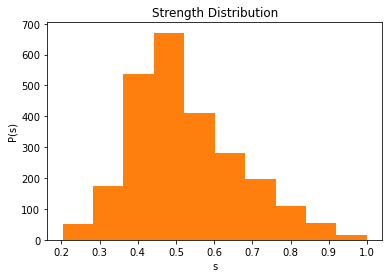

In [8]:
G_list_plot = [G_List_null_model[rnd.randint(0, len(G_List_null_model)-1)] , base_scale_free]
plot_strength_dist(G_list_plot)

In [9]:
def Attack_Highest_Weight(base_graph, number_of_attacks):
    if(number_of_attacks < 1):
        print("Number of attacks should be greater than zero.")

    if(number_of_attacks > base_graph.number_of_edges()):
        print("Number of attacks should be less then edge count.")
    G = base_graph.copy()
    for i in range(number_of_attacks):
        highest_weighted_edge = sorted(G.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)[0]
        G.remove_edge(highest_weighted_edge[0], highest_weighted_edge[1])
    return G

random_graph = G_List_null_model[rnd.randint(0, len(G_List_null_model)-1)]
G_attacked = Attack_Highest_Weight(random_graph, number_of_attacks)

In [10]:
def Attack_Random(base_graph, number_of_attacks):
    if(number_of_attacks < 1):
        print("Number of attacks should be greater than zero.")

    if(number_of_attacks > base_graph.number_of_edges()):
        print("Number of attacks should be less then edge count.")

    G = base_graph.copy()
    for i in range(number_of_attacks):
        random_edge = list(G.edges())[rnd.randint(0, G.number_of_edges() - 1)]
        G.remove_edge(random_edge[0], random_edge[1])
    return G

random_graph = G_List_null_model[rnd.randint(0, len(G_List_null_model)-1)]
G_random_attacked = Attack_Random(random_graph, number_of_attacks)

In [ ]:
def getEdges(A):
    edges = []

    vertexCount = A.shape[0]
    for i in range(0, vertexCount):
        for j in range(0, vertexCount):
            if i != j and A[i][j] != 0:
                edges.append([i,j,A[i][j]])
    return edges
        

def BellmanFordAlgo(A, startID):
    
    vertexCount = A.shape[0]
    dist = {} 
    previous = {} 

    for i in range(0, vertexCount):
        dist[i] = float('Inf') 
        previous[i] = None
    dist[startID] = 0 

    edges = getEdges(A)

    changed = True
    relaxationTime = vertexCount-1
    while relaxationTime > 0 and changed: 
        changed = False
        relaxationTime = relaxationTime - 1
        for edge in edges:
             if dist[edge[1]] > dist[edge[0]] + edge[2]:
                 dist[edge[1]]  = dist[edge[0]] + edge[2]
                 previous[edge[1]] = edge[0]
                 changed = True
    #print("It converges after " + str( vertexCount -1 - relaxationTime) + " times.")

    results = []
    for i in range(0, vertexCount):
        results.append([i,dist[i],previous[i]])

    return results

def HarmonicMean(A):
    vertexCount = A.shape[0]
    sum = 0.0

    for i in range(0, vertexCount):
        resultOfBellman = BellmanFordAlgo(A, i)
        for result in resultOfBellman:
            if result[0] != i :
                if result[1] != float('Inf') :
                    if result[1] == 0:
                        print("WARNING: Encountered with 0")
                    else:
                        sum += 1 / result[1]
    
    if sum == 0 :
        #print("WARNING: Harmonic Mean equals to zero")
        return 0

    return (vertexCount* (vertexCount-1)* (1/sum))

def globalEfficiency(adj_matrix):
    h = HarmonicMean(adj_matrix)
    if h == 0 :
        return 0
    return (1/h)

In [ ]:
def reciprocalOfEdges(G):
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (1 / G[e[0]][e[1]]['weight'])